##### This model follows the same fine tuning as model 06, but with the maximum lengths for model inputs increased. As with model 04 and the first pretrained checkpoint used, the goal is for this to increase the amount of data available for the model to make prediction based on long passages of text.

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [5]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer
model: https://huggingface.co/sshleifer/distilbart-xsum-1-1

In [8]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [9]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [10]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [11]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [12]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [13]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [14]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [15]:
num_train_epochs = 10
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [16]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [17]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=10)

Epoch 1/10
212/212 [==============================] - 32s 103ms/step - loss: 5.6866 - val_loss: 5.0542
Epoch 2/10
212/212 [==============================] - 20s 95ms/step - loss: 4.9404 - val_loss: 4.8342
Epoch 3/10
212/212 [==============================] - 20s 95ms/step - loss: 4.6203 - val_loss: 4.7386
Epoch 4/10
212/212 [==============================] - 20s 95ms/step - loss: 4.3972 - val_loss: 4.6871
Epoch 5/10
212/212 [==============================] - 21s 97ms/step - loss: 4.2195 - val_loss: 4.6635
Epoch 6/10
212/212 [==============================] - 20s 95ms/step - loss: 4.0742 - val_loss: 4.6547
Epoch 7/10
212/212 [==============================] - 21s 97ms/step - loss: 3.9643 - val_loss: 4.6521
Epoch 8/10
212/212 [==============================] - 21s 97ms/step - loss: 3.8743 - val_loss: 4.6551
Epoch 9/10
212/212 [==============================] - 20s 95ms/step - loss: 3.8105 - val_loss: 4.6601
Epoch 10/10
212/212 [==============================] - 20s 95ms/step - loss: 3.77

# Visualize model

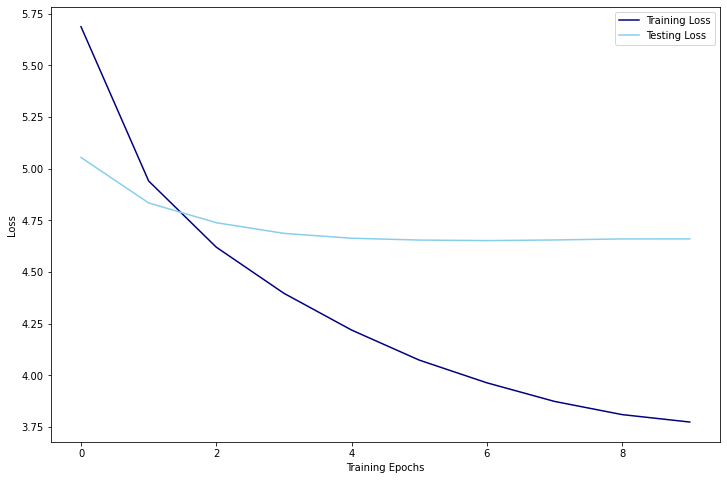

In [18]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. The loss functions of this model look very similar to those of model 6.

# Rouge scores for training data

In [19]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [29:58<00:00,  8.48s/it]


In [20]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 79.59183673469387
recall: 8.51528384279476
f-measure: 15.384615384615385
***************
rouge2
precision: 22.916666666666664
recall: 2.4070021881838075
f-measure: 4.356435643564357
***************
rougeL
precision: 53.06122448979592
recall: 5.676855895196507
f-measure: 10.256410256410255
***************
rougeLsum
precision: 79.59183673469387
recall: 8.51528384279476
f-measure: 15.384615384615385
***************


# Rouge scores for test data

In [21]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [22]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [08:21<00:00,  8.49s/it]


In [23]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 50.0
recall: 11.353711790393014
f-measure: 18.505338078291814
***************
rouge2
precision: 3.9215686274509802
recall: 0.8771929824561403
f-measure: 1.4336917562724014
***************
rougeL
precision: 26.923076923076923
recall: 6.11353711790393
f-measure: 9.964412811387902
***************
rougeLsum
precision: 42.30769230769231
recall: 9.606986899563319
f-measure: 15.658362989323843
***************


# Example model-generated summaries

In [24]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [25]:
print(rand_indexes)

[24, 16, 27]


In [26]:
#Reference summary example 1
print(test_labels[24])

Darcy and Fitzwilliam leave Rosings the next morning, and Lady Catherine invites the parish party over to dine with her.
Lady Catherine tries to talk Elizabeth into staying another month, but Elizabeth is determined to soon return home as planned.
During the last week of Elizabeth and Maria's visit, they frequently are invited to Lady Catherine's, where she gives much advice on how they should travel and who should accompany them and how they should pack.
On Saturday before she leaves, Elizabeth is alone with Collins for a while, giving him the opportunity to thank her for coming, to say again how lucky they are that Lady Catherine invites them over so often, and to stress how happy he and Charlotte are.
Maria and Elizabeth leave on the chaise, and in four hours are at Mr. Gardiner's house, where they will spend a few days before they and Jane return to Longbourn.
Elizabeth finds Jane doing well, and cannot wait to tell her of Darcy's proposal, although she is not sure how much she sho

In [29]:
#Model summary example 1
print(test_preds[24])

Lady Catherine Collins and Mrs Collins are invited to Mrs. Collins to visit Darcy to the house of Lady Catherine.
Mrs Collins, and Collins says that Darcy will not go to the party.
Mr. Collins asks Lady Catherine to Miss Darcy, and Lady Catherine will not be able


In [30]:
#Reference summary example 2
print(test_labels[16])

In this chapter Huck meets with Mary Jane, one of the Wilks girls with whom he has become especially close, and he tells her that the king and duke are frauds and that he has taken the money from them.
He writes a note to her telling her where he has hidden the gold.
By the end of the chapter, real trouble for the king and duke has come with the arrival of the legitimate heirs.
It seems a confrontation will soon follow.
To make a long story short, there's a lengthy dispute between the two pairs of heirs.
As time passes, however, it becomes increasingly clear that the king and duke are frauds.
All of the tension comes to a fountainhead at the burial of Peter Wilks, where the gold is discovered.
Leaving the king and duke to pay the penalty for their fraudulent scheming, Huck breaks free from the group and runs back to the river, where Jim has been waiting for him.
Unfortunately, the king and duke follow him to the raft, angry that Huck was trying to give them the slip."
So the foursome c

In [31]:
#Model summary example 2
print(test_preds[16])

: Novel : 4, Huckers and Mrs. Lothrop insists that she will not go to the house, but she wants to go back to her room.


In [32]:
#Reference summary example 3
print(test_labels[27])

The centaur leaves them on the farther shore of the river of boiling blood, and they set out through a strange, barren woods of trees with dingy leaves and poisonous thorns, where Harpies, half human, half bird, lament.
This is the second round, Virgil tells Dante.
Dante hears wailing but sees no one and is bewildered.
Virgil tells him to break off a twig from one of the trees; immediately blood and a voice come out of the wound, asking why Dante is adding to his torment.
The speaker turns out to be a famous statesman and poet named Pier delle Vigne, who had served an emperor and been imprisoned on charges of treachery.
He killed himself in despair.
Now he explains that he had never betrayed his master, and is glad to think that Dante will tell the truth about him when he returns to the world of living souls.
He tells how those who have been violent against their own bodies here become thorn trees, and even at the Last Judgment will not again enter their bodies-only each dead body will

In [33]:
#Model summary example 3
print(test_preds[27])

This is one of the world's most famous city in the world, telling them that they would have to go to the forest.
He tells the story of Virgil, and Virgil tells him that he has been killed.


# Evaluation of model

Based on rouge scores, this model performed better than the baseline model. It also scored better in almost every category than all previous fine tuned models. It does score lower on Rouge2 f1-measure than the the previous model (06_model). However, overall its performance is superior. Similarly to the last model, the example generated summaries are more subjectively understandable than those of the first model and do seem to have content related to that of their reference summaries, but still do not represent actual logical summaries of the related texts